<a href="https://colab.research.google.com/github/KimuYounguWoo/machine-learning-programming/blob/main/%ED%83%80%EC%9D%B4%ED%83%80%EB%8B%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 타이타닉 데이터셋 에측 모델 만들기


## 데이터 준비 및 전처리

### 데이터 불러오기

In [116]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
import pandas as pd

data_tr = pd.read_csv('/content/drive/MyDrive/simp_data/train.csv')
data_te = pd.read_csv('/content/drive/MyDrive/simp_data/test.csv')

data_tes = pd.read_csv('/content/drive/MyDrive/simp_data/test.csv')

### 결측치 확인
이 데이터에서 이상치를 어떻게 처리할 지에 대해서, 확인

In [118]:
data_tr.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

나이 데이터는 생존률에 영향을 미칠 것으로 예상되고, Cabin, 즉 객실 데이터는 이상치가 너무 많아 사용할 수 없을 것으로 예상

In [119]:
# 객실 등급에 따른 생존률

data_tr[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


객실 등급이 높을 수록(1에 가까울수록) 생존률이 높다.

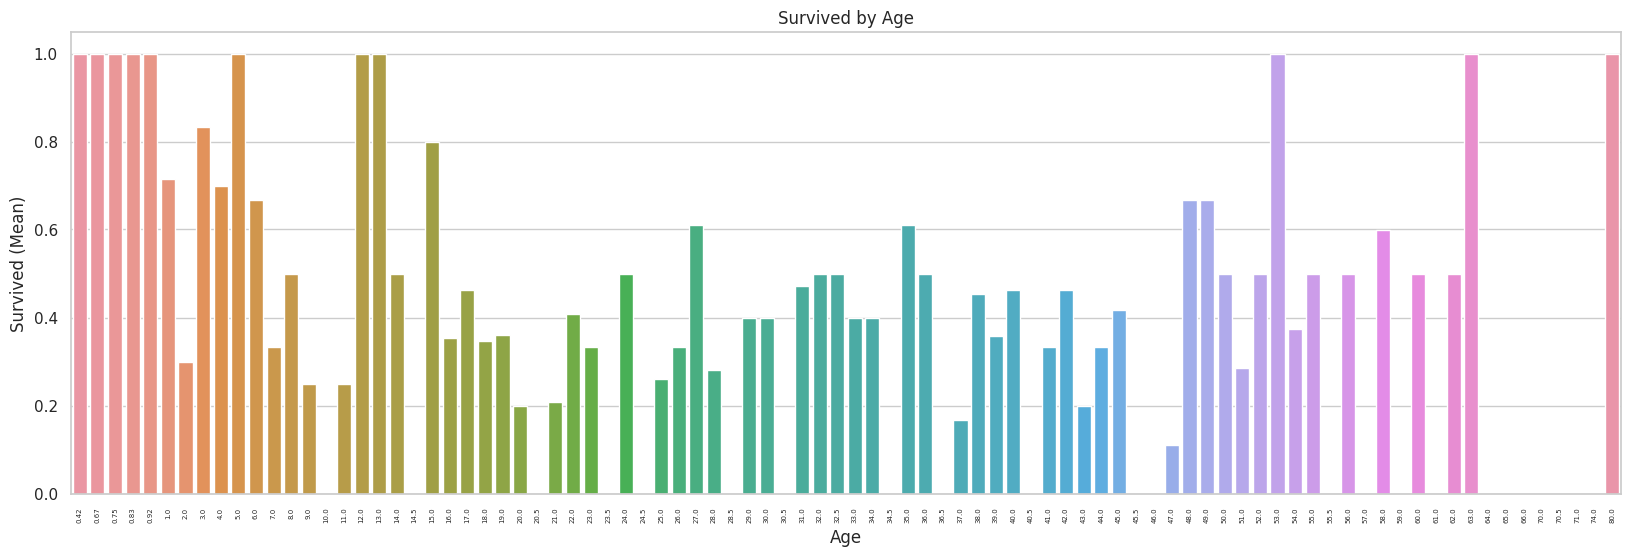

In [120]:
# 나이에 따른 생존률
import seaborn as sns
import matplotlib.pyplot as plt

age_survived_mean = data_tr[['Age', 'Survived']].groupby(['Age'], as_index=False).mean()

sns.set(style="whitegrid")
plt.figure(figsize=(20, 6))
sns.barplot(x='Age', y='Survived', data=age_survived_mean)
plt.xlabel('Age')
plt.ylabel('Survived (Mean)')
plt.title('Survived by Age')
plt.xticks(rotation=90, fontsize = 5)
plt.show()

나이가 매우 어리거나, 많을 경우 생존률이 높은 것을 확인

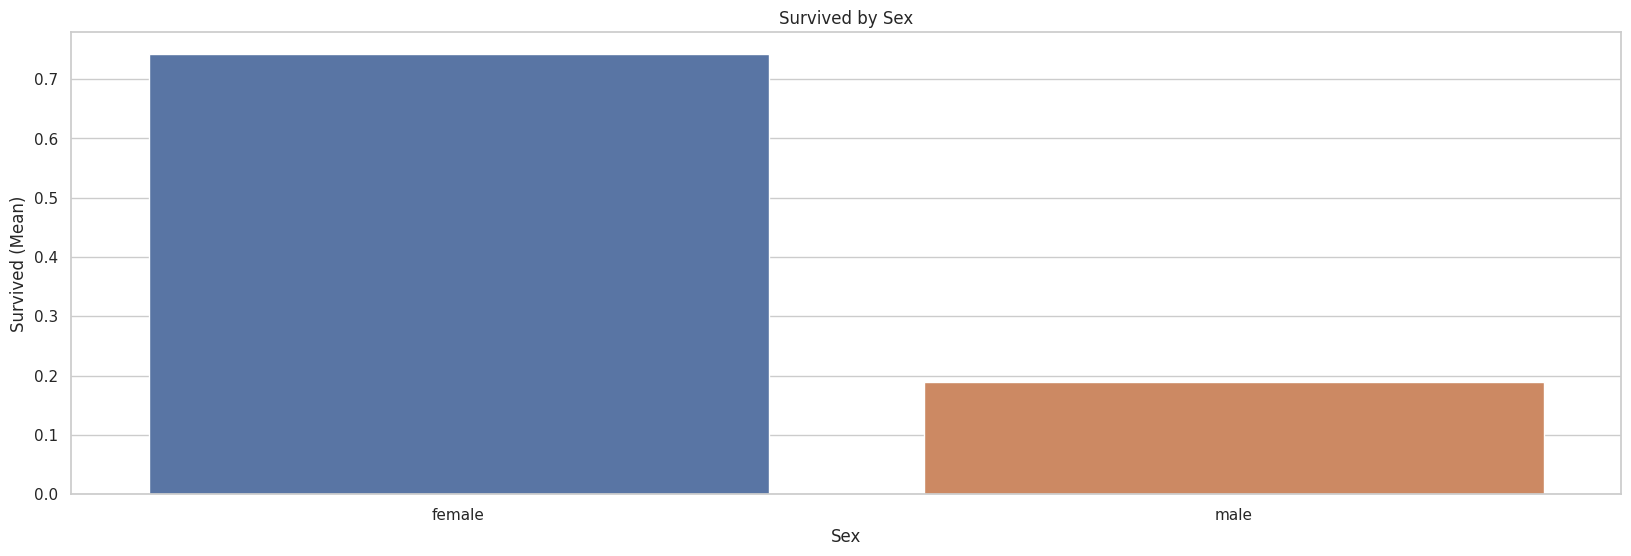

In [121]:


sex_survive_mean = data_tr[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

sns.set(style="whitegrid")
plt.figure(figsize=(20, 6))
sns.barplot(x='Sex', y='Survived', data=sex_survive_mean)
plt.xlabel('Sex')
plt.ylabel('Survived (Mean)')
plt.title('Survived by Sex')
plt.show()

성별에 따른 생존률은 여자가 높은 것으로 추정

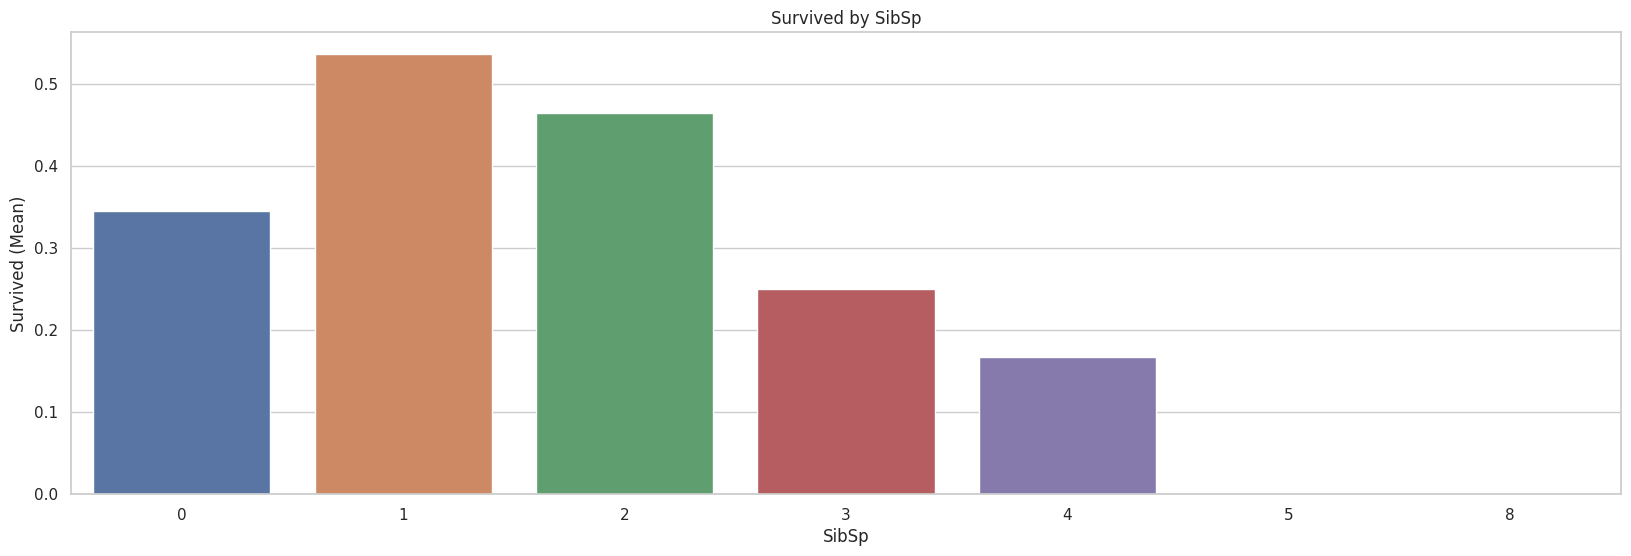

In [122]:
# Parch = 동반한 부모 및 자식의 수
# SibSp = 동반한 형제, 자매, 연인의 수

sib_survived_mean = data_tr[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean()

sns.set(style="whitegrid")
plt.figure(figsize=(20, 6))
sns.barplot(x='SibSp', y='Survived', data=sib_survived_mean)
plt.xlabel('SibSp')
plt.ylabel('Survived (Mean)')
plt.title('Survived by SibSp')
plt.show()

동반자가 많을 경우, 생존률이 낮아지는 경향

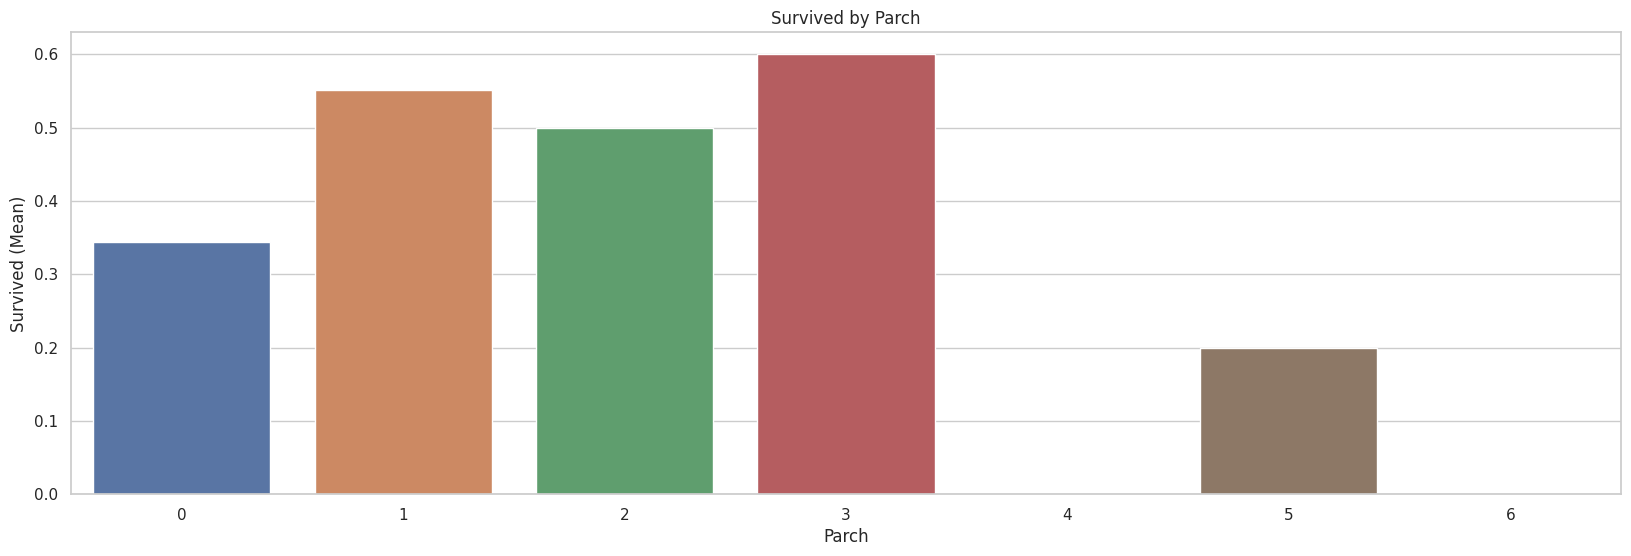

In [123]:
parch_survive_mean = data_tr[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean()

sns.set(style="whitegrid")
plt.figure(figsize=(20, 6))
sns.barplot(x='Parch', y='Survived', data=parch_survive_mean)
plt.xlabel('Parch')
plt.ylabel('Survived (Mean)')
plt.title('Survived by Parch')
plt.show()

자식이나 부모가 많은 경우, 생존률이 높아지는 경향

### 결론
1. 나이는 생존률에 영향을 주며, 결측치가 많지 않으므로 유의미한 데이터를 통해 결측치를 채워야한다.
2. Cabin(객실) 데이터는 생존률에 영향을 줄 수 있으나, 결측치가 너무 많기에 제거
3. 이름, 승선항, 티켓 고유 번호, 승객 고유 번호, 티켓의 요금 등은, 생존률에 큰 영향을 미치지 않을 것으로 생각하여, 제거

In [124]:
data_tr.drop('PassengerId', axis=1, inplace=True)
data_te.drop('PassengerId', axis=1, inplace=True)

data_tr.drop('Cabin', axis=1, inplace=True)
data_te.drop('Cabin', axis=1, inplace=True)

data_tr.drop('Name', axis=1, inplace=True)
data_te.drop('Name', axis=1, inplace=True)

data_tr.drop('Fare', axis=1, inplace=True)
data_te.drop('Fare', axis=1, inplace=True)

data_tr.drop('Embarked', axis=1, inplace=True)
data_te.drop('Embarked', axis=1, inplace=True)

data_tr.drop('Ticket', axis=1, inplace=True)
data_te.drop('Ticket', axis=1, inplace=True)


In [125]:
# 평균 나이로 결측치 처리
data_tr['Age'] = data_tr['Age'].fillna(data_tr['Age'].mean())
data_te['Age'] = data_te['Age'].fillna(data_te['Age'].mean())

In [126]:
# 성별을 학습을 위해 숫자로 처리
data_tr['Sex']=data_tr['Sex'].apply(lambda x:1 if (x=='female') else 0)
data_te['Sex']=data_te['Sex'].apply(lambda x:1 if (x=='female') else 0)

In [127]:
print(data_tr.isna().sum())
print(data_te.isna().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
dtype: int64
Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
dtype: int64


## 머신러닝


### 모델 생성 및 예측 :: SGD 1st

In [128]:
# 학습 데이터
# input -> Survived 열을 제거하고, to_numpy()
# target -> Survied만

target = data_tr['Survived'].to_numpy()
input = data_tr[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']].to_numpy()

In [129]:
from sklearn.model_selection import train_test_split

train_input,test_input,train_target,test_target = train_test_split(
    input,
    target,
    test_size=0.2,
    random_state=201935231
  )

In [130]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [131]:
from sklearn.linear_model import SGDClassifier


sc = SGDClassifier(loss='log_loss', max_iter=1000, random_state=201935231)
sc.fit(train_scaled, train_target)
print(f'train score: {sc.score(train_scaled, train_target)}\ntest score: {sc.score(test_scaled, test_target)}')

train score: 0.7879213483146067
test score: 0.7374301675977654


In [132]:
import numpy as np

sc = SGDClassifier(loss='log_loss', random_state=201935231)

train_score = []
test_score = []

classes = np.unique(train_target)

In [133]:
for _ in range(0, 300):
    sc.partial_fit(train_scaled, train_target, classes=classes)

    train_score.append(sc.score(train_scaled, train_target))
    test_score.append(sc.score(test_scaled, test_target))

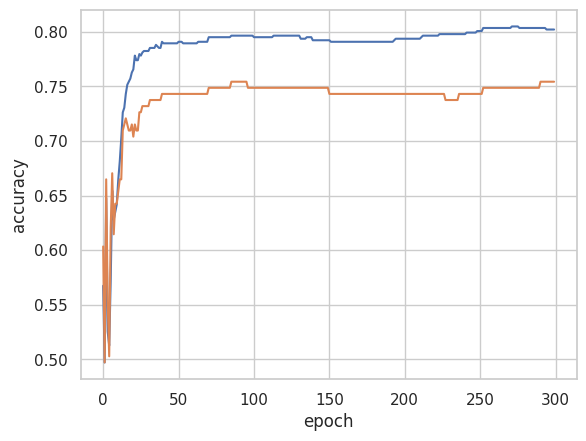

In [134]:
import matplotlib.pyplot as plt

plt.plot(train_score)
plt.plot(test_score)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()


그렇게 효율이 좋지 않은 듯함.<br>
나이 데이터가 너무 많아보여, 구간화를 한 후 똑같이 진행

### 모델 생성 및 예측 :: SGD 2nd

In [135]:
# age 구간화
# 청소년 : 0
# 청년 : 1
# 장년 : 2
# 중년 : 3
# 노년 : 4

ranges = [0,16,26,36,62,100]
labels = [0,1,2,3,4]
data_tr["Age"]=pd.cut(data_tr['Age'],ranges,right=False,labels=labels)
data_te["Age"]=pd.cut(data_te['Age'],ranges,right=False,labels=labels)
target = data_tr['Survived'].to_numpy()
input = data_tr[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']].to_numpy()

In [136]:
from sklearn.model_selection import train_test_split

train_input,test_input,train_target,test_target = train_test_split(
    input,
    target,
    test_size=0.2,
    random_state=201935231
  )

In [137]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [138]:
from sklearn.linear_model import SGDClassifier


sc = SGDClassifier(loss='log_loss', max_iter=1000, random_state=201935231)
sc.fit(train_scaled, train_target)
print(f'train score: {sc.score(train_scaled, train_target)}\ntest score: {sc.score(test_scaled, test_target)}')

train score: 0.7865168539325843
test score: 0.7374301675977654


In [139]:
import numpy as np

sc = SGDClassifier(loss='log_loss', random_state=201935231)

train_score = []
test_score = []

classes = np.unique(train_target)

In [140]:
for _ in range(0, 500):
    sc.partial_fit(train_scaled, train_target, classes=classes)

    train_score.append(sc.score(train_scaled, train_target))
    test_score.append(sc.score(test_scaled, test_target))

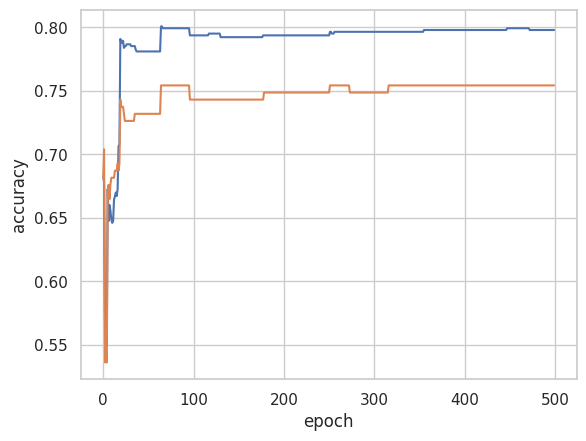

In [141]:
import matplotlib.pyplot as plt

plt.plot(train_score)
plt.plot(test_score)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

아까보다는 차이가 줄었지만, 여전히 점수가 좋지는 않음<br>
대략 300번 정도에서 가장 효율이 좋으므로 300번만 돌려서 확인

In [142]:
sc = SGDClassifier(loss='log_loss', random_state=201935231)
for _ in range(0, 500):
    sc.partial_fit(train_scaled, train_target, classes=classes)

print(f'train score: {sc.score(train_scaled, train_target)}\ntest score: {sc.score(test_scaled, test_target)}')

train score: 0.797752808988764
test score: 0.7541899441340782


In [143]:
sc = SGDClassifier(loss='hinge', random_state=201935231)
for _ in range(0, 500):
    sc.partial_fit(train_scaled, train_target, classes=classes)

print(f'train score: {sc.score(train_scaled, train_target)}\ntest score: {sc.score(test_scaled, test_target)}')

train score: 0.7893258426966292
test score: 0.776536312849162


In [144]:
sc = SGDClassifier(loss='huber', random_state=201935231)
for _ in range(0, 500):
    sc.partial_fit(train_scaled, train_target, classes=classes)

print(f'train score: {sc.score(train_scaled, train_target)}\ntest score: {sc.score(test_scaled, test_target)}')

train score: 0.7893258426966292
test score: 0.776536312849162


In [145]:
sc = SGDClassifier(loss='modified_huber', random_state=201935231)
for _ in range(0, 500):
    sc.partial_fit(train_scaled, train_target, classes=classes)

print(f'train score: {sc.score(train_scaled, train_target)}\ntest score: {sc.score(test_scaled, test_target)}')

train score: 0.7794943820224719
test score: 0.7150837988826816


SGD에서는 epoch는 300 이상, 손실 함수는 ```'huber', 'hinge'```가 높은 점수를 가짐


```'huber'```에서 다른 Parameter를 바꿔서 진행

In [146]:
sc = SGDClassifier(loss='huber', random_state=201935231, alpha = 0.0001)
for _ in range(0, 500):
    sc.partial_fit(train_scaled, train_target, classes=classes)

print(f'train score: {sc.score(train_scaled, train_target)}\ntest score: {sc.score(test_scaled, test_target)}')

train score: 0.7893258426966292
test score: 0.776536312849162


In [147]:
test_list = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
for i in test_list:
  sc = SGDClassifier(loss='huber', random_state=201935231, alpha = i)
  for _ in range(0, 500):
    sc.partial_fit(train_scaled, train_target, classes=classes)
  print(f'alpha = {i}\ntrain score: {sc.score(train_scaled, train_target)}\ntest score: {sc.score(test_scaled, test_target)}\n')


alpha = 0.0001
train score: 0.7893258426966292
test score: 0.776536312849162

alpha = 0.001
train score: 0.7893258426966292
test score: 0.776536312849162

alpha = 0.01
train score: 0.7893258426966292
test score: 0.776536312849162

alpha = 0.1
train score: 0.7345505617977528
test score: 0.7374301675977654

alpha = 1
train score: 0.6165730337078652
test score: 0.6145251396648045

alpha = 10
train score: 0.6165730337078652
test score: 0.6145251396648045

alpha = 100
train score: 0.6165730337078652
test score: 0.6145251396648045



In [148]:
test_list = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
for i in test_list:
  sc = SGDClassifier(loss='hinge', random_state=201935231, alpha = i)
  for _ in range(0, 500):
    sc.partial_fit(train_scaled, train_target, classes=classes)
  print(f'alpha = {i}\ntrain score: {sc.score(train_scaled, train_target)}\ntest score: {sc.score(test_scaled, test_target)}\n')


alpha = 0.0001
train score: 0.7893258426966292
test score: 0.776536312849162

alpha = 0.001
train score: 0.7893258426966292
test score: 0.776536312849162

alpha = 0.01
train score: 0.7893258426966292
test score: 0.776536312849162

alpha = 0.1
train score: 0.7893258426966292
test score: 0.776536312849162

alpha = 1
train score: 0.7148876404494382
test score: 0.7150837988826816

alpha = 10
train score: 0.6165730337078652
test score: 0.6145251396648045

alpha = 100
train score: 0.6165730337078652
test score: 0.6145251396648045



alpha < 0.01 이여야 높은 점수를 얻으며, default 값으로도 최적값을 뽑아내므로 따로 설정 X


In [149]:
sc = SGDClassifier(loss='huber', random_state=201935231, penalty = 'l1')
for _ in range(0, 500):
    sc.partial_fit(train_scaled, train_target, classes=classes)

print(f'train score: {sc.score(train_scaled, train_target)}\ntest score: {sc.score(test_scaled, test_target)}')

train score: 0.7893258426966292
test score: 0.776536312849162


In [150]:
sc = SGDClassifier(loss='huber', random_state=201935231, penalty = 'elasticnet')
for _ in range(0, 500):
    sc.partial_fit(train_scaled, train_target, classes=classes)

print(f'train score: {sc.score(train_scaled, train_target)}\ntest score: {sc.score(test_scaled, test_target)}')

train score: 0.7893258426966292
test score: 0.776536312849162


In [151]:
sc = SGDClassifier(loss='hinge', random_state=201935231, penalty = 'l1')
for _ in range(0, 500):
    sc.partial_fit(train_scaled, train_target, classes=classes)

print(f'train score: {sc.score(train_scaled, train_target)}\ntest score: {sc.score(test_scaled, test_target)}')

train score: 0.7893258426966292
test score: 0.776536312849162


In [152]:
sc = SGDClassifier(loss='hinge', random_state=201935231, penalty = 'elasticnet')
for _ in range(0, 500):
    sc.partial_fit(train_scaled, train_target, classes=classes)

print(f'train score: {sc.score(train_scaled, train_target)}\ntest score: {sc.score(test_scaled, test_target)}')

train score: 0.7893258426966292
test score: 0.776536312849162


규제 정책도 크게 상관하지 않는 것으로 보임
<br>
최종적으로 SGDClassifier의 HyperParamter는 <br>
```
loss = 'hinge' || 'huber'
alpha = 0.0001
penalty = 'l1' || 'l2' || 'elasticnet'
```
으로 볼 수 있다.

### 결정 트리


In [153]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=201935231)
dt.fit(train_scaled, train_target)

print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.851123595505618
0.7988826815642458


일단, 모두 default 값으로 두었을 때 점수가 SGD보다 더 높게 나오는 것을 확인할 수 있지만 학습 점수가 높아 과대적합이 의심된다.

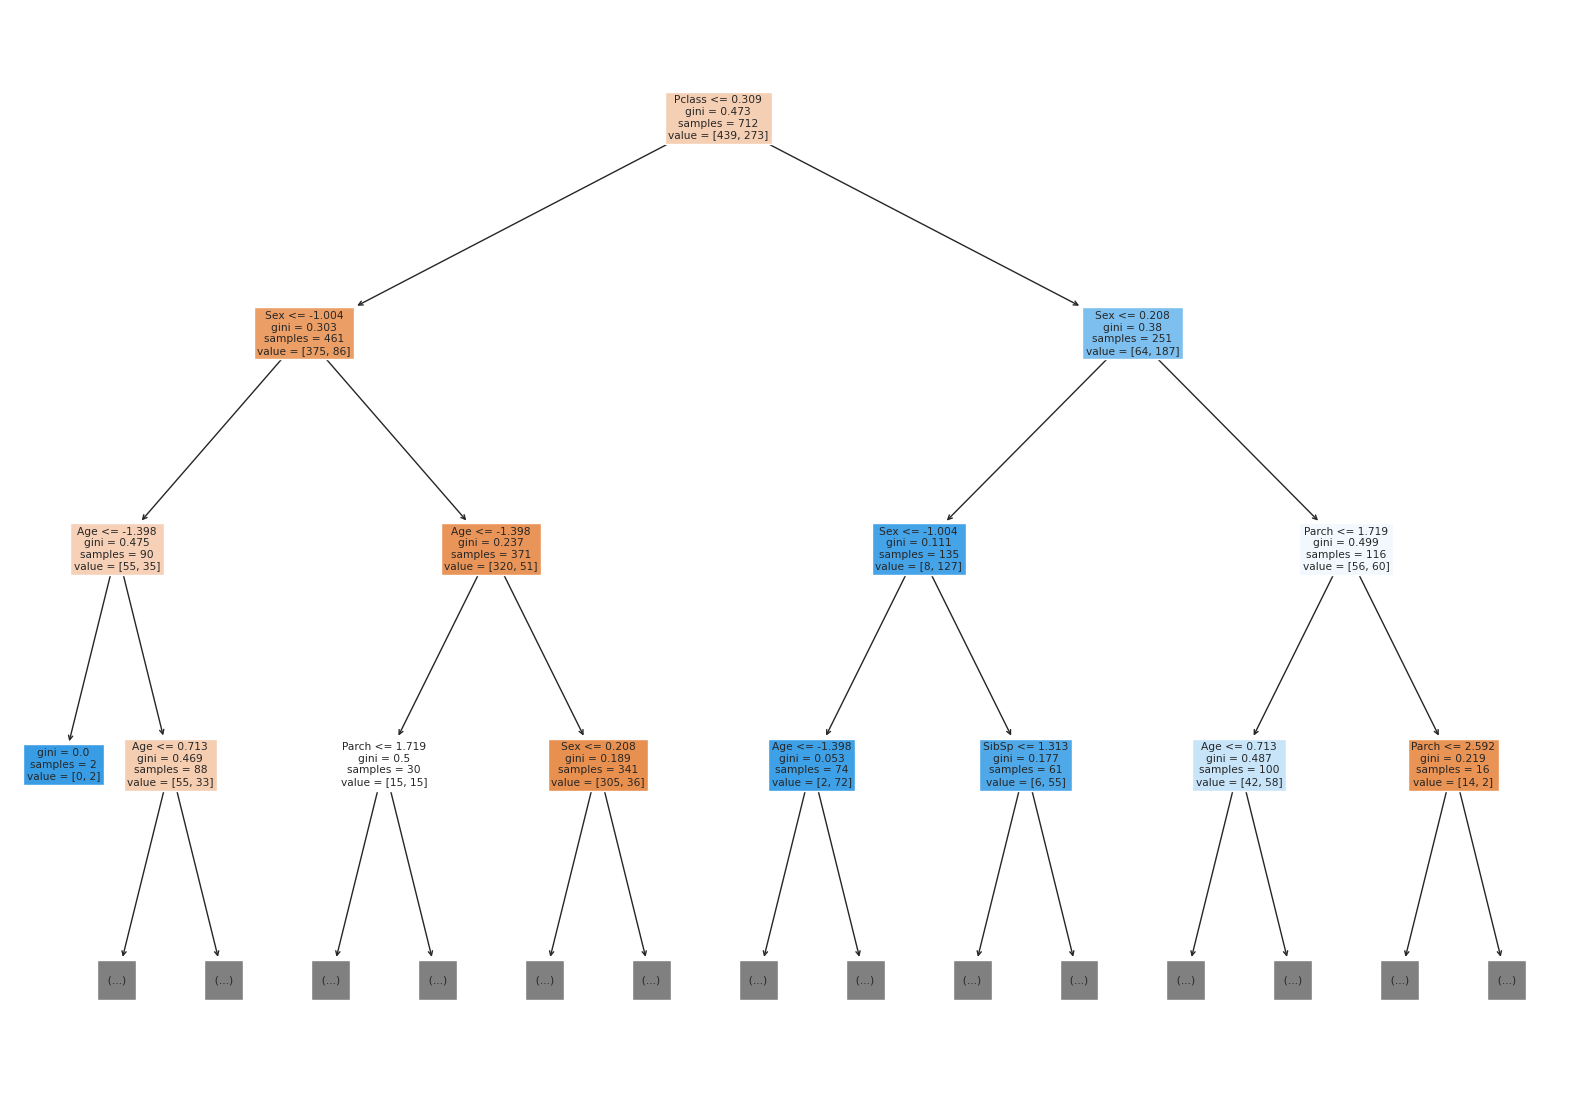

In [154]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,14))
plot_tree(dt, max_depth=3, filled=True, feature_names=['Sex', 'Pclass', 'Age', 'Parch', 'SibSp'])
plt.show()

# 중요하게 생각하는 특성이 5개이므로 깊이를 늘려주자

음성 클래스와 양성 클래스를 비교<br>
주황색 = 음성 클래스 / 파랑색 = 양성 클래스<br>
1. 객실의 등급이 높을 수록
2. 성별이 남자일수록
3. 나이가 어릴수록
4. 나이가 너무 어리지 않다면...
생존률이 가장 높다.



In [155]:
print(dt.feature_importances_)

[0.17053765 0.53512397 0.10552001 0.14501887 0.04379949]


특성의 중요성은
1. 객실 등급
2. 성별
3. 부모 또는 자식의 수
4. 나이
5. 형제, 자매, 부부의 수

In [156]:
for i in range(1, 4, 1):
  dt = DecisionTreeClassifier(max_depth=i, random_state=201935231)
  dt.fit(train_input, train_target)

  print(dt.score(train_input, train_target))
  print(dt.score(test_input, test_target))
  print(dt.score(train_input, train_target) - dt.score(test_input, test_target))
  print()

0.7893258426966292
0.776536312849162
0.012789529847467174

0.7893258426966292
0.776536312849162
0.012789529847467174

0.8089887640449438
0.7821229050279329
0.026865859017010885



max_depth = 1 or 2 일때 가장 괜찮다.<br>
다음은 최소 불순도 설정

In [157]:
gini = [0.0001, 0.001, 0.01, 0.1, 1]

for i in gini:
  dt = DecisionTreeClassifier(max_depth=1, random_state=201935231, min_impurity_decrease = i)
  dt.fit(train_input, train_target)

  print(dt.score(train_input, train_target))
  print(dt.score(test_input, test_target))
  print(dt.score(train_input, train_target) - dt.score(test_input, test_target))
  print()

0.7893258426966292
0.776536312849162
0.012789529847467174

0.7893258426966292
0.776536312849162
0.012789529847467174

0.7893258426966292
0.776536312849162
0.012789529847467174

0.7893258426966292
0.776536312849162
0.012789529847467174

0.6165730337078652
0.6145251396648045
0.002047894043060716



1 이하면, 차이가 없다.<br>
그러므로 최적 값은<br>
```
max_depth = 1 || 2
min_impurity_decrease = default ( < 1)
```


In [166]:

winslet = data_te.iloc[0].to_numpy()
# ['Sex', 'Pclass', 'Age', 'Parch', 'SibSp'])
sum = 0.0
dt = DecisionTreeClassifier(max_depth=2, random_state=201935231)
dt.fit(train_input, train_target)

def isSurvived(name, person):
    isSurvive = '죽었다.' if dt.predict([person])[0] == 0 else '살았다.'
    print(name, '는 ', isSurvive,
          ' --> ', round(max(dt.predict_proba([person])[0]), 4))
    return max(dt.predict_proba([person])[0])

for i in range(0, 100):
  test = data_te.iloc[i].to_numpy()
  name = data_tes['Name'].iloc[i]
  sum += isSurvived(name, test)

print(f'테스트 데이터 100개의 점수는 {round(sum%100, 3)}')

Kelly, Mr. James 는  죽었다.  -->  0.8625
Wilkes, Mrs. James (Ellen Needs) 는  살았다.  -->  0.5172
Myles, Mr. Thomas Francis 는  죽었다.  -->  0.8625
Wirz, Mr. Albert 는  죽었다.  -->  0.8625
Hirvonen, Mrs. Alexander (Helga E Lindqvist) 는  살았다.  -->  0.5172
Svensson, Mr. Johan Cervin 는  죽었다.  -->  0.8625
Connolly, Miss. Kate 는  살았다.  -->  0.5172
Caldwell, Mr. Albert Francis 는  죽었다.  -->  0.8625
Abrahim, Mrs. Joseph (Sophie Halaut Easu) 는  살았다.  -->  0.5172
Davies, Mr. John Samuel 는  죽었다.  -->  0.8625
Ilieff, Mr. Ylio 는  죽었다.  -->  0.8625
Jones, Mr. Charles Cresson 는  죽었다.  -->  0.6111
Snyder, Mrs. John Pillsbury (Nelle Stevenson) 는  살았다.  -->  0.9407
Howard, Mr. Benjamin 는  죽었다.  -->  0.8625
Chaffee, Mrs. Herbert Fuller (Carrie Constance Toogood) 는  살았다.  -->  0.9407
del Carlo, Mrs. Sebastiano (Argenia Genovesi) 는  살았다.  -->  0.9407
Keane, Mr. Daniel 는  죽었다.  -->  0.8625
Assaf, Mr. Gerios 는  죽었다.  -->  0.8625
Ilmakangas, Miss. Ida Livija 는  살았다.  -->  0.5172
Assaf Khalil, Mrs. Mariana (Miriam")" 는  살

86% 정도의 정확도가 나왔음

### 랜덤 포레스트

### 히스토그램 기반 그레디언트 부스팅